<a href="https://colab.research.google.com/github/michelucci/TensorFlow20-Notes/blob/master/complete_usecases/Dogs_and_cats_classification_with_TensorFlow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs and cats classification with TensorFlow 2.0

(C) 2019 Umberto Michelucci

www.toelt.ai


In this notebook I will develop a complete use-case, in which I will build  a classifier for images of dogs and cats, building several models, increasing the accuracy with each models. I will use TensorFlow 2.0, ImageGenerator, data augmentation, and much more. 

In [0]:
import numpy as np
import shutil
import matplotlib.pyplot as plt
import os
import zipfile

In [2]:
# Let's select TensorFlow 2.x
%tensorflow_version 2.x 
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0-rc0


In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

We define a ```plot_acc_loss``` to make plotting easier later on in the notebook.

In [0]:
def plot_acc_loss(history, EPOCHS):
    # plot the training loss and accuracy
    fig = plt.figure(figsize=(9, 3), dpi=100)
    plt.subplots_adjust(wspace = 0.6 )
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(np.arange(0, EPOCHS), history.history['accuracy'], 'b', label='training accuracy')
    ax1.plot(np.arange(0, EPOCHS), history.history['val_accuracy'], 'r', label='validation accuracy');
    ax1.set_title('Accuracy')
    ax1.set_xlabel("Number of epochs ")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim(0,1.0)
    ax1.legend(loc="best")


    ax2.plot(np.arange(0, EPOCHS), history.history["loss"], label="training loss")
    ax2.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="validation loss")
    ax2.set_title("Loss")
    ax2.set_xlabel("Number of epochs ")
    ax2.set_ylabel("Loss")
    #ax2.set_ylim(0,1.0)
    ax2.legend(loc="best");
    
    fig.tight_layout()
    
    print('Loss:')
    print('  - loss [training dataset]: {0:.3f}'.format(history.history['loss'][-1]))
    print('  - loss [validation dataset]: {0:.3f}'.format(history.history['val_loss'][-1]))
    print('')
    print('Accuracy:')
    print('  - accuracy [training dataset]: {:.2f}%'.format(100*history.history['accuracy'][-1]))
    print('  - accuracy [validation dataset]: {:.2f}%'.format(100*history.history['val_accuracy'][-1]))
    
    return fig

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-09-12 07:06:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  78.0MB/s    in 0.8s    

2019-09-12 07:06:46 (78.0 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

First of all we need to organize the files, since they come in different directories. the files are in the following directories

- ```/tmp/cats_and_dogs_filtered/train/dogs``` --> Training dogs images
- ```/tmp/cats_and_dogs_filtered/train/cats``` --> Training cats images
- ```/tmp/cats_and_dogs_filtered/validation/dogs``` --> Validation dogs images
- ```/tmp/cats_and_dogs_filtered/validation/cats``` --> Validation cats images

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
train_cat_fnames = os.listdir(train_cats_dir)
print (train_cat_fnames[:3])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print (train_dog_fnames[:3])

['cat.481.jpg', 'cat.172.jpg', 'cat.835.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg']


The following cell will print out how many images in each dataset we have

In [8]:
print ('total training cat images:', len(os.listdir(train_cats_dir)))
print ('total training dog images:', len(os.listdir(train_dogs_dir)))
print ('total validation cat images:', len(os.listdir(validation_cats_dir)))
print ('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


The images are not much (the dataset is much bigger), but in this way the training will be really quick and you can try different things.

In [0]:
train_dir = '/tmp/cats_and_dogs_filtered/train'
val_dir = '/tmp/cats_and_dogs_filtered/validation'

The most efficient way of dealing with data is to use an ```ImageDataGenerator```, in this way we can, for example, do data augmentation in a very easy and straightforward way.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

First we need to rescale the images (note that the following line does nothing to the images __yet__. It only defines what we want to do with the images.)

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The ```flow_from_directory``` simply scan the directory given as a first parameter. Additionally we get the images already resized to ```target_size=(150,150)``` pixels, and we get batches each containing 20 images.

# CNN Model - v1

Now is time to build a CNN and see how it performs on our data. let's start with something easy. A simply ```Sequential()``` model.

In [13]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

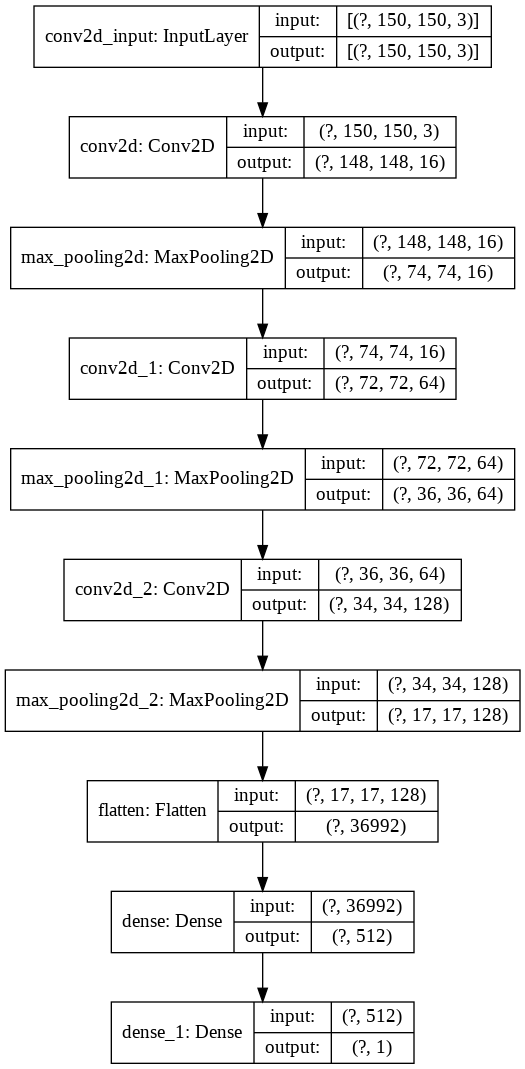

In [14]:
from tensorflow import keras
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Training the model is really easy now. Remember to activate GPU support in Google Colab. It will make the training faster ;-)

In [15]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps, 
                            # remember batch_size = 20
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100/100 - 16s - loss: 0.9207 - accuracy: 0.5350 - val_loss: 0.6911 - val_accuracy: 0.5230
Epoch 2/10
100/100 - 12s - loss: 0.6436 - accuracy: 0.6570 - val_loss: 0.5853 - val_accuracy: 0.6870
Epoch 3/10
100/100 - 12s - loss: 0.5496 - accuracy: 0.7210 - val_loss: 0.5835 - val_accuracy: 0.7230
Epoch 4/10
100/100 - 12s - loss: 0.4510 - accuracy: 0.7920 - val_loss: 0.5608 - val_accuracy: 0.7280
Epoch 5/10
100/100 - 12s - loss: 0.3903 - accuracy: 0.8265 - val_loss: 0.6200 - val_accuracy: 0.7220
Epoch 6/10
100/100 - 12s - loss: 0.2774 - accuracy: 0.8875 - val_loss: 0.6536 - val_accuracy: 0.7060
Epoch 7/10
100/100 - 12s - loss: 0.2032 - accuracy: 0.9070 - val_loss: 0.7732 - val_accuracy: 0.7130
Epoch 8/10
100/100 - 12s - loss: 0.1298 - accuracy: 0.9535 - val_loss: 0.7897 - val_accuracy: 0.7020
Epoch 9/10
100/100 - 12s - loss: 0.0937 - accuracy: 0.9710 - val_loss: 1.2494 - val_accuracy: 0.74

The network is learning, but is clearly overfitting as you can see from the plots below.

Loss:
  - loss [training dataset]: 0.184
  - loss [validation dataset]: 0.296

Accuracy:
  - accuracy [training dataset]: 92.40%
  - accuracy [validation dataset]: 87.90%


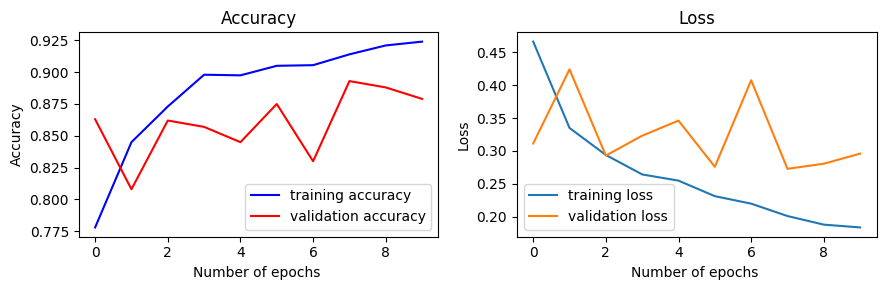

In [43]:
fig = plot_acc_loss(history, 10)

# Transfer Learning with VGG16

Now we can try to use a pre-trained network, and re-train the last dense layers for our dogs and cats images.

In [0]:
keras.backend.clear_session()
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras import Model

base_model=VGG16(include_top=False, weights='imagenet')
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) 
preds=Dense(1,activation='sigmoid')(x)
model=Model(inputs=base_model.input,outputs=preds)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Note that we don't want to retrain the layers of VGG16, only ours. So we need to set their ```trainable``` parameter to ```False```.

In [0]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Now we have __only__ 526337 parameters that can be trained. Now we can train the network again.

In [29]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/10
100/100 - 54s - loss: 0.4661 - accuracy: 0.7780 - val_loss: 0.3112 - val_accuracy: 0.8630
Epoch 2/10
100/100 - 51s - loss: 0.3349 - accuracy: 0.8450 - val_loss: 0.4240 - val_accuracy: 0.8080
Epoch 3/10
100/100 - 51s - loss: 0.2938 - accuracy: 0.8730 - val_loss: 0.2929 - val_accuracy: 0.8620
Epoch 4/10
100/100 - 51s - loss: 0.2642 - accuracy: 0.8980 - val_loss: 0.3231 - val_accuracy: 0.8570
Epoch 5/10
100/100 - 51s - loss: 0.2548 - accuracy: 0.8975 - val_loss: 0.3461 - val_accuracy: 0.8450
Epoch 6/10
100/100 - 51s - loss: 0.2312 - accuracy: 0.9050 - val_loss: 0.2758 - val_accuracy: 0.8750
Epoch 7/10
100/100 - 51s - loss: 0.2198 - accuracy: 0.9055 - val_loss: 0.4073 - val_accuracy: 0.8300
Epoch 8/10
100/100 - 51s - loss: 0.2010 - accuracy: 0.9140 - val_loss: 0.2728 - val_accuracy: 0.8930
Epoch 9/10
100/100 - 51s - loss: 0.1879 - accuracy: 0.9210 - val_loss: 0.2805 - val_accuracy: 0.8880
Epoch 10/10
100/100 - 51s - loss: 0.1837 - accuracy: 0.9240 - val_loss: 0.2959 - val_accura

Loss:
  - loss [training dataset]: 0.184
  - loss [validation dataset]: 0.296

Accuracy:
  - accuracy [training dataset]: 92.40%
  - accuracy [validation dataset]: 87.90%


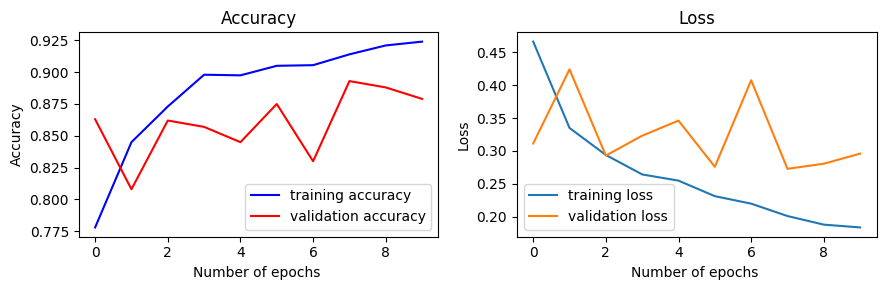

In [44]:
fig = plot_acc_loss(history, 10)

# Data Augmentation

In [0]:
train_datagen_aug = ImageDataGenerator(rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True, 
                             fill_mode="nearest")

test_datagen_aug = ImageDataGenerator(rotation_range=40, 
                             width_shift_range=0.2,
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2,
                             horizontal_flip=True, 
                             fill_mode="nearest")

- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- shear_range is for randomly applying shearing transformations
- zoom_range is for randomly zooming inside pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [46]:
train_generator = train_datagen_aug.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen_aug.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [47]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=100,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/10
200/200 - 106s - loss: 1.6509 - accuracy: 0.8850 - val_loss: 2.0816 - val_accuracy: 0.8560
Epoch 2/10
200/200 - 105s - loss: 1.6470 - accuracy: 0.8863 - val_loss: 2.0225 - val_accuracy: 0.8635
Epoch 3/10
200/200 - 105s - loss: 1.6330 - accuracy: 0.8873 - val_loss: 1.8109 - val_accuracy: 0.8770
Epoch 4/10
200/200 - 105s - loss: 1.5082 - accuracy: 0.8967 - val_loss: 1.7490 - val_accuracy: 0.8810
Epoch 5/10
200/200 - 105s - loss: 1.5635 - accuracy: 0.8940 - val_loss: 1.7068 - val_accuracy: 0.8840
Epoch 6/10
200/200 - 105s - loss: 1.4662 - accuracy: 0.8995 - val_loss: 1.7011 - val_accuracy: 0.8855
Epoch 7/10
200/200 - 104s - loss: 1.5311 - accuracy: 0.8970 - val_loss: 1.3957 - val_accuracy: 0.9055
Epoch 8/10
200/200 - 105s - loss: 1.5400 - accuracy: 0.8960 - val_loss: 1.7994 - val_accuracy: 0.8765
Epoch 9/10
200/200 - 105s - loss: 1.5659 - accuracy: 0.8938 - val_loss: 3.1557 - val_accuracy: 0.7890
Epoch 10/10
200/200 - 104s - loss: 1.4034 - accuracy: 0.9043 - val_loss: 1.8374 - 

Loss:
  - loss [training dataset]: 1.403
  - loss [validation dataset]: 1.837

Accuracy:
  - accuracy [training dataset]: 90.43%
  - accuracy [validation dataset]: 87.65%


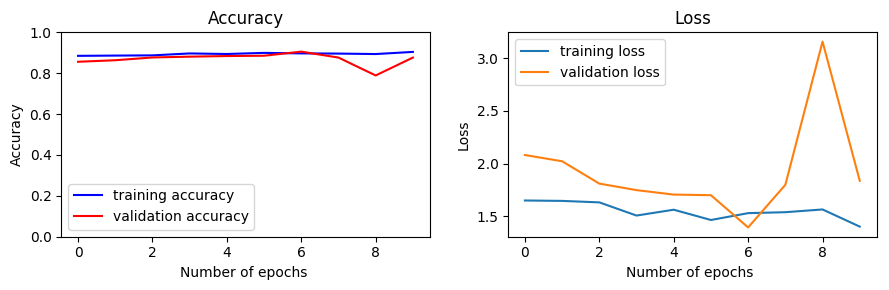

In [50]:
fig = plot_acc_loss(history, 10)